In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os
from collections import Counter

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
# Define dataset path
data_dir = r"C:\Users\vivek\Desktop\PDEU\Deep Learning\archive\eyepac-light-v2-512-jpg"  # Replace with the actual path
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "validation")
test_dir = os.path.join(data_dir, "test")

In [3]:
# Function to check class distribution
def check_class_distribution(directory):
    class_counts = Counter()
    for subdir, dirs, files in os.walk(directory):
        if len(files) > 0:
            class_name = os.path.basename(subdir)
            class_counts[class_name] += len(files)
    print("Class Distribution:")
    for class_name, count in class_counts.items():
        print(f"{class_name}: {count}")

check_class_distribution(train_dir)
check_class_distribution(val_dir)
check_class_distribution(test_dir)

Class Distribution:
NRG: 4000
RG: 4000
Class Distribution:
NRG: 385
RG: 385
Class Distribution:
NRG: 385
RG: 385


In [4]:
# Define parameters
img_size = (224, 224)
batch_size = 16

In [5]:
# Data Augmentation & Loading
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(train_dir, target_size=img_size,
                                              batch_size= batch_size, class_mode='binary')
val_generator = datagen.flow_from_directory(val_dir, target_size=img_size,
                                            batch_size= batch_size, class_mode='binary')
test_generator = datagen.flow_from_directory(test_dir, target_size=img_size,
                                             batch_size= batch_size, class_mode='binary', shuffle=False)

Found 8000 images belonging to 2 classes.
Found 770 images belonging to 2 classes.
Found 770 images belonging to 2 classes.


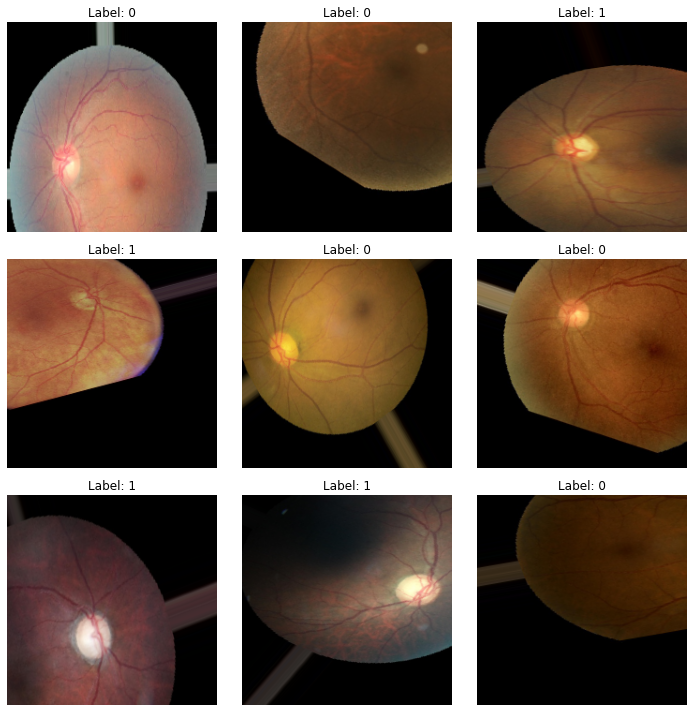

In [6]:
import matplotlib.pyplot as plt

# Fetch one batch from the train_generator
images, labels = next(train_generator)

# Plot the first 9 images from the batch
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f'Label: {int(labels[i])}')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [7]:
print(train_generator.class_indices)

{'NRG': 0, 'RG': 1}


In [8]:
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights = dict(enumerate(class_weights))

In [9]:
# Function to create improved models
def create_model(base_model):
    base_model.trainable = True
    for layer in base_model.layers[:-50]:
        layer.trainable = False
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [10]:
models = {
    "Xception": tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    "MobileNetV2": tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    "DenseNet121": tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
}

In [11]:
# Train and Evaluate Each Model
model_histories = {}

for model_name, base_model in models.items():
    print(f"Training model: {model_name}")
    model = create_model(base_model)
    
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=10,
        class_weight=class_weights,
        callbacks=[early_stopping]
    )
    
    model_histories[model_name] = history  # Store history for plotting
    loss, acc = model.evaluate(test_generator)
    print(f"{model_name} Test Accuracy: {acc:.4f}")
    model.save(f"{model_name}_glaucoma_classifier.h5")


Training model: Xception
Epoch 1/10
500/500 [==============================] - 1548s 3s/step - loss: 0.6128 - accuracy: 0.6939 - val_loss: 0.5144 - val_accuracy: 0.7701
Epoch 2/10
500/500 [==============================] - 1111s 2s/step - loss: 0.4903 - accuracy: 0.7657 - val_loss: 0.4069 - val_accuracy: 0.8104
Epoch 3/10
500/500 [==============================] - 1193s 2s/step - loss: 0.4458 - accuracy: 0.7959 - val_loss: 0.4157 - val_accuracy: 0.8000
Epoch 4/10
500/500 [==============================] - 1239s 2s/step - loss: 0.4175 - accuracy: 0.8099 - val_loss: 0.4034 - val_accuracy: 0.8221
Epoch 5/10
500/500 [==============================] - 1630s 3s/step - loss: 0.4052 - accuracy: 0.8239 - val_loss: 0.3839 - val_accuracy: 0.8468
Epoch 6/10
500/500 [==============================] - 1506s 3s/step - loss: 0.3913 - accuracy: 0.8338 - val_loss: 0.3636 - val_accuracy: 0.8377
Epoch 7/10
500/500 [==============================] - 1755s 4s/step - loss: 0.3739 - accuracy: 0.8378 - val_los

C:\Users\vivek\AppData\Roaming\Python\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training model: MobileNetV2
Epoch 1/10
500/500 [==============================] - 352s 689ms/step - loss: 0.7338 - accuracy: 0.6720 - val_loss: 0.6026 - val_accuracy: 0.7065
Epoch 2/10
500/500 [==============================] - 332s 665ms/step - loss: 0.6036 - accuracy: 0.7295 - val_loss: 0.6536 - val_accuracy: 0.7221
Epoch 3/10
500/500 [==============================] - 329s 658ms/step - loss: 0.5372 - accuracy: 0.7611 - val_loss: 0.7790 - val_accuracy: 0.6740
Epoch 4/10
500/500 [==============================] - 329s 657ms/step - loss: 0.5065 - accuracy: 0.7725 - val_loss: 0.4773 - val_accuracy: 0.7974
Epoch 5/10
500/500 [==============================] - 328s 657ms/step - loss: 0.4661 - accuracy: 0.7916 - val_loss: 0.5007 - val_accuracy: 0.7974
Epoch 6/10
500/500 [==============================] - 329s 658ms/step - loss: 0.4450 - accuracy: 0.7949 - val_loss: 0.5510 - val_accuracy: 0.8091
Epoch 7/10
500/500 [==============================] - 328s 656ms/step - loss: 0.4339 - accuracy:

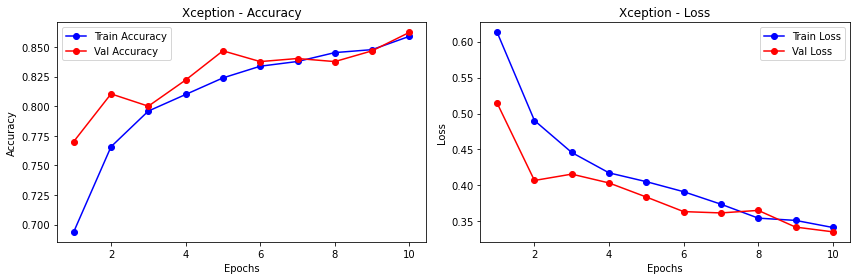

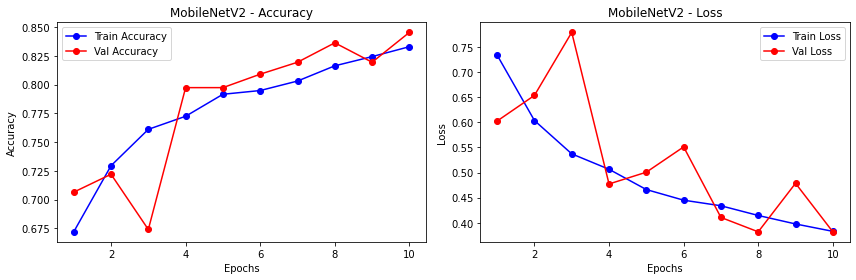

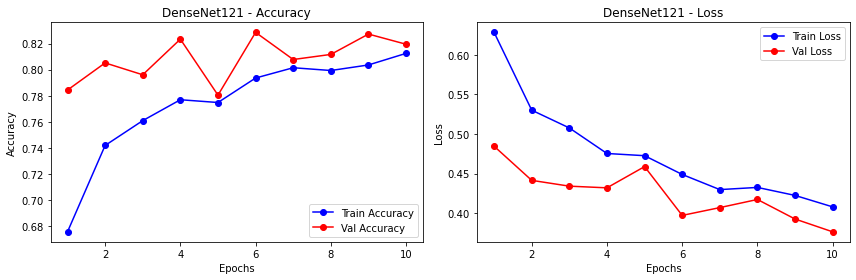

In [13]:
def plot_learning_curve(model_histories):
    for model_name, history in model_histories.items():
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs = range(1, len(acc) + 1)

        plt.figure(figsize=(12, 4))
        
        # Accuracy
        plt.subplot(1, 2, 1)
        plt.plot(epochs, acc, 'bo-', label='Train Accuracy')
        plt.plot(epochs, val_acc, 'ro-', label='Val Accuracy')
        plt.title(f'{model_name} - Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        # Loss
        plt.subplot(1, 2, 2)
        plt.plot(epochs, loss, 'bo-', label='Train Loss')
        plt.plot(epochs, val_loss, 'ro-', label='Val Loss')
        plt.title(f'{model_name} - Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()

plot_learning_curve(model_histories)


In [14]:
# Binary Classification Prediction Function
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# Prediction function
def predict_image(image_path, model):
    img = image.load_img(image_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale like training images

    prediction = model.predict(img_array)
    class_label = "Referable Glaucoma (RG)" if prediction[0][0] > 0.5 else "Non-Referable Glaucoma (NRG)"
    return class_label

# Define the image size used in training
img_size = (224, 224)  # or whatever size you used

# Load the model
model = tf.keras.models.load_model("MobileNetV2_glaucoma_classifier.h5")

# Test image path
image_path = r"C:\Users\vivek\Desktop\PDEU\Deep Learning\archive\eyepac-light-v2-512-jpg\test\NRG\EyePACS-TRAIN-NRG-2900.jpg"

# Predict
result = predict_image(image_path, model)
print("Prediction:", result)

1/1 [==============================] - 1s 760ms/step
Prediction: Referable Glaucoma (RG)
